In [6]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import logging
(logging.getLogger('theano.gof.compilelock').setLevel(logging.CRITICAL))

np.random.seed(42)

## Generate Data
We generate style demand data by store, and also aggregeate it by style for the first example

We assume that last year/period, we had 1,000 customers

In [7]:
prior_customers = 1000

In [8]:
styles = np.arange(1, 6)
styles

array([1, 2, 3, 4, 5])

We need the share of each style as a % of total sales, which we draw from a beta distribution with mode of $1/Number of Styles$ and then normalize to add up to 100%.

In [41]:
style_demand_percent = np.random.beta(a=1, b=len(styles)-1, size=len(styles))
style_demand_percent = style_demand_percent/np.sum(style_demand_percent)
[f'{p:.2%}' for p in style_demand_percent]

['32.86%', '18.71%', '5.30%', '30.55%', '12.58%']

In [42]:
df_style_demand = pd.DataFrame(list(zip(styles-1, style_demand_percent)), columns=['style_id', 'style_percent'])
df_style_demand.loc[:, 'style_demand'] = np.round(prior_customers * df_style_demand['style_percent'], 0)
df_style_demand.loc[:, 'style'] = 'Style ' + df_style_demand['style_id'].astype(str)
df_style_demand

,style_id,style_percent,style_demand,style
0,0,0.328598,329.0,Style 0
1,1,0.187059,187.0,Style 1
2,2,0.053012,53.0,Style 2
3,3,0.305496,305.0,Style 3
4,4,0.125836,126.0,Style 4


We create 3 stores and assume demand is evently split ±50% among with some random noise:

In [43]:
stores = np.arange(1, 4)
stores

array([1, 2, 3])

In [44]:
store_sales_percent = np.random.uniform(low=1/len(stores)*0.5, high=1/len(stores)*1.5, size=len(stores))
store_sales_percent = store_sales_percent/np.sum(store_sales_percent)
df_store_sales = pd.DataFrame(list(zip(stores-1, store_sales_percent)), columns=['store_id', 'store_percent'])
df_store_sales.loc[:, 'store_sales'] = np.round(prior_customers * df_store_sales['store_percent'], 0)
df_store_sales.loc[:, 'store'] = 'Store ' + df_store_sales['store_id'].astype(str)
df_store_sales

,store_id,store_percent,store_sales,store
0,0,0.442909,443.0,Store 0
1,1,0.202506,203.0,Store 1
2,2,0.354585,355.0,Store 2


Then we combine styles and stores to simulate store level demand for each style, with a bit of extra noise

In [45]:
df_style_demand.loc[:, 'key'] = 1
df_store_sales.loc[:, 'key'] = 1
df_store_style_demand = pd.merge(df_style_demand, df_store_sales).drop('key', axis=1)
df_style_demand.drop('key', axis=1, inplace=True)
df_store_style_demand.loc[:,"style_percent_noisy"] = df_store_style_demand["style_percent"] + np.random.gamma(0.1, 0.1,len(df_store_style_demand))
df_store_style_demand.loc[:,"store_style_percent"] = df_store_style_demand["style_percent_noisy"] * df_store_style_demand["store_percent"] 
df_store_style_demand.loc[:,"store_style_demand"] = np.round(df_store_style_demand["store_style_percent"] * prior_customers, 0)

In [46]:
df_store_style_demand

,style_id,style_percent,style_demand,style,store_id,store_percent,store_sales,store,style_percent_noisy,store_style_percent,store_style_demand
0,0,0.328598,329.0,Style 0,0,0.442909,443.0,Store 0,0.328829,0.145641,146.0
1,0,0.328598,329.0,Style 0,1,0.202506,203.0,Store 1,0.328625,0.066548,67.0
2,0,0.328598,329.0,Style 0,2,0.354585,355.0,Store 2,0.329228,0.116739,117.0
3,1,0.187059,187.0,Style 1,0,0.442909,443.0,Store 0,0.187297,0.082956,83.0
4,1,0.187059,187.0,Style 1,1,0.202506,203.0,Store 1,0.187059,0.037880,38.0
5,1,0.187059,187.0,Style 1,2,0.354585,355.0,Store 2,0.240756,0.085369,85.0
6,2,0.053012,53.0,Style 2,0,0.442909,443.0,Store 0,0.071133,0.031505,32.0
7,2,0.053012,53.0,Style 2,1,0.202506,203.0,Store 1,0.073821,0.014949,15.0
8,2,0.053012,53.0,Style 2,2,0.354585,355.0,Store 2,0.053421,0.018942,19.0
9,3,0.305496,305.0,Style 3,0,0.442909,443.0,Store 0,0.305496,0.135307,135.0


Lastly, we assume this year we'll grow at 2x, so we add our forecasted demand for store and style combo

In [47]:
forecasted_customers = prior_customers * 2

In [48]:
df_style_demand.loc[:,"forecasted_style_demand"] = np.round(df_style_demand["style_percent"] * forecasted_customers, 0)
df_style_demand

,style_id,style_percent,style_demand,style,forecasted_style_demand
0,0,0.328598,329.0,Style 0,657.0
1,1,0.187059,187.0,Style 1,374.0
2,2,0.053012,53.0,Style 2,106.0
3,3,0.305496,305.0,Style 3,611.0
4,4,0.125836,126.0,Style 4,252.0


In [49]:
df_store_sales.loc[:,"forecasted_store_sales"] = np.round(df_store_sales["store_percent"] * forecasted_customers, 0)
df_store_sales

,store_id,store_percent,store_sales,store,key,forecasted_store_sales
0,0,0.442909,443.0,Store 0,1,886.0
1,1,0.202506,203.0,Store 1,1,405.0
2,2,0.354585,355.0,Store 2,1,709.0


In [145]:
df_store_style_demand.loc[:,"forecasted_style_demand"] = np.round(df_store_style_demand["style_percent_noisy"] * forecasted_customers, 0)
df_store_style_demand.loc[:,"forecasted_store_style_demand"] = np.round(df_store_style_demand["store_style_percent"] * forecasted_customers, 0)

In [130]:
style_idx = df_store_style_demand['style_id'].values
store_idx = df_store_style_demand['store_id'].values

## The Demand Model


#### Demand = Customers x Store % x Style %

Our first model is a simple beta-binomial model, at the style level only. 

In [74]:
def model_1(df_style_demand, forecasted_customers):

    N = len(df_style_demand)

    with pm.Model() as model:

        style_share = pm.Beta('Style Share', 
                              alpha=df_style_demand['style_demand'].values, 
                              beta=prior_customers - df_style_demand['style_demand'].values, 
                              shape=N)

        style_demand = pm.Binomial('Style Demand', 
                                   n=forecasted_customers, 
                                   p=style_share, 
                                   observed=df_style_demand['forecasted_style_demand'].values)
    return model

In [52]:
# hyper_alpha_sd = pm.Uniform('hyper_alpha_sd', lower=0, upper=50)
# hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10)

# hyper_mu_sd = pm.Uniform('hyper_mu_sd', lower=0, upper=50)
# hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60)

# alpha = pm.Gamma('alpha', mu=hyper_alpha_mu, sd=hyper_alpha_sd, shape=n_participants)
# mu = pm.Gamma('mu', mu=hyper_mu_mu, sd=hyper_mu_sd, shape=n_participants)

# y_est = pm.NegativeBinomial('y_est', 
#                             mu=mu[participants_idx], 
#                             alpha=alpha[participants_idx], 
#                             observed=messages['time_delay_seconds'].values)

In [146]:
def model_2(df_store_style_demand, forecasted_customers):

    n_styles = len(df_store_style_demand['style'].unique())
    n_values = len(df_store_style_demand)
    
    with pm.Model() as model:

        hyper_alpha_mu = pm.Gamma('hyper_alpha_mu', 100, 1)
        hyper_alpha_sd = pm.Gamma('hyper_alpha_sd', 100, 1)

        hyper_beta_mu = pm.Gamma('hyper_beta_mu',100, 1)
        hyper_beta_sd = pm.Gamma('hyper_beta_sd',100, 1)
        
        alpha = pm.Gamma('alpha', mu=hyper_alpha_mu, sd=hyper_alpha_sd, shape=n_styles)
        beta = pm.Gamma('beta', mu=hyper_beta_mu, sd=hyper_beta_sd, shape=n_styles)
        
        style_share = pm.Beta('Style Share', 
                              alpha=alpha[style_idx], 
                              beta=beta[style_idx], 
                              shape=n_values)

        style_demand = pm.Binomial('Style Demand', 
                                   n=forecasted_customers, 
                                   p=style_share, 
                                   observed=df_store_style_demand['forecasted_style_demand'].values)
    return model

In [147]:
style_model_simple = model_2(df_store_style_demand, forecasted_customers)
style_model_simple

In [148]:
n_samples = 10000
n_chains = 3
seed = 22
SAMPLE_KWARGS = {
    'draws': n_samples,
    'tune': int(n_samples/2),
    'chains': n_chains,
    'cores': n_chains,
    'random_seed': [seed + i for i in range(n_chains)] if n_chains > 1 else seed,
    'nuts_kwargs': {'target_accept': 0.9}
}

In [149]:
with style_model_simple:
    style_trace_simple = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [Style Share_logodds__, beta_log__, alpha_log__, hyper_beta_sd_log__, hyper_beta_mu_log__, hyper_alpha_sd_log__, hyper_alpha_mu_log__]
100%|██████████| 15000/15000 [03:43<00:00, 67.22it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


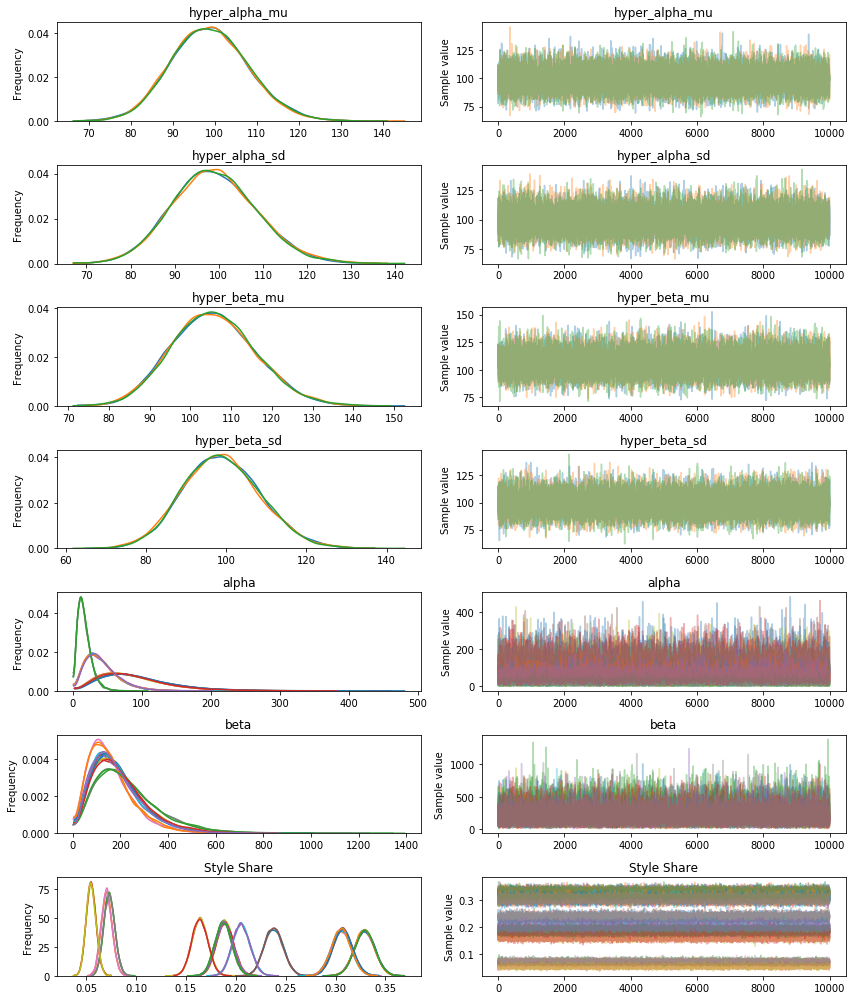

In [150]:
pm.traceplot(style_trace_simple);

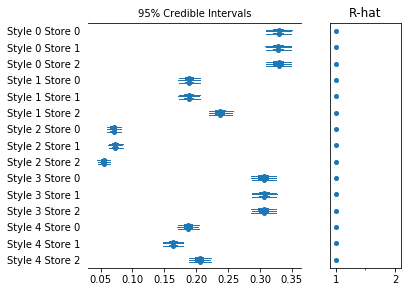

In [154]:
pm.forestplot(style_trace_simple, varnames=['Style Share'], ylabels=(df_store_style_demand['style'] + ' ' + df_store_style_demand['store']).values);

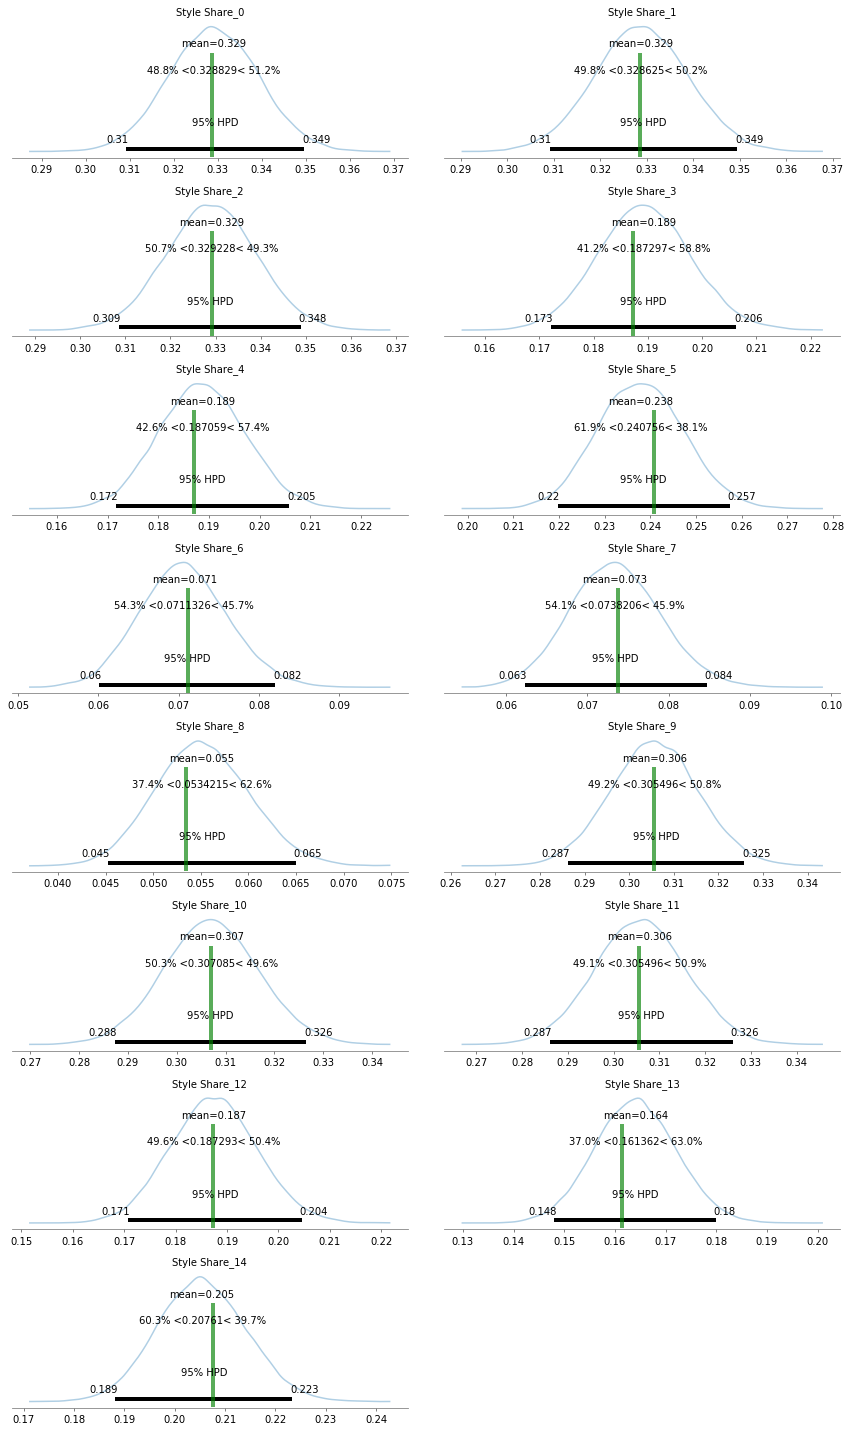

In [158]:
with style_model_simple:
    pm.plot_posterior(style_trace_simple, 
                      kde_plot=True, 
                      varnames=['Style Share'], 
                      ref_val=df_store_style_demand['style_percent_noisy'].values)

In [120]:
with style_model_simple:
    style_ppc_simple = pm.sample_ppc(style_trace_simple)

100%|██████████| 10000/10000 [00:02<00:00, 4551.54it/s]


In [121]:
style_ppc_simple

{'Style Demand': array([[668, 351, 105, 588, 248],
        [601, 413, 142, 622, 235],
        [678, 365,  93, 620, 252],
        ...,
        [636, 376,  92, 601, 255],
        [660, 418, 108, 640, 259],
        [687, 361, 104, 612, 259]])}

In [122]:
df_style_demand

,style_id,style_percent,style_demand,style,forecasted_style_demand
0,0,0.328598,329.0,Style 0,657.0
1,1,0.187059,187.0,Style 1,374.0
2,2,0.053012,53.0,Style 2,106.0
3,3,0.305496,305.0,Style 3,611.0
4,4,0.125836,126.0,Style 4,252.0


0


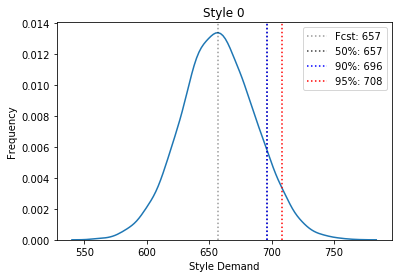

1


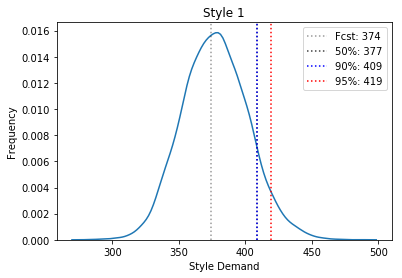

2


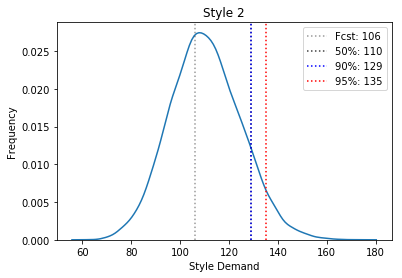

3


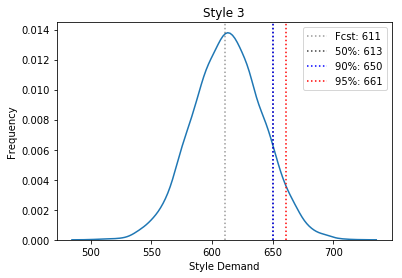

4


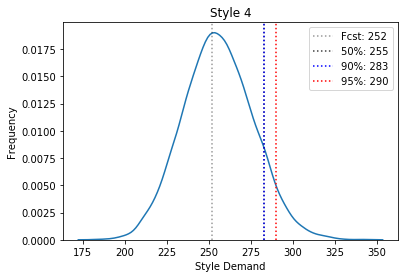

In [123]:
for i, s in df_style_demand.iterrows():
    print(i)
    dt = style_ppc_simple['Style Demand'][:, i]
    quantiles = pm.quantiles(dt, [50, 75, 90, 95])

    obs_mean = int(s['forecasted_style_demand'])
    
    ax = plt.subplot()
    sns.distplot(dt, 
                 kde=True, hist=False, ax=ax)
    ax.axvline(obs_mean, c='k', alpha=0.4, linestyle='dotted', label=f'Fcst: {obs_mean}')
    ax.axvline(quantiles[90], c='k', alpha=0.75, linestyle='dotted', label=f'50%: {quantiles[50]}')
    ax.axvline(quantiles[90], c='b', linestyle='dotted', label=f'90%: {quantiles[90]}')
    ax.axvline(quantiles[95], c='r', linestyle='dotted', label=f'95%: {quantiles[95]}')
    ax.set(title=s['style'], xlabel='Style Demand', ylabel='Frequency')
    plt.legend(loc='best')
    plt.show()

## Demand By Store

In [214]:
df_store_style_demand.head(20)

,style_id,style_percent,style_demand,style,forecasted_style_demand,store_id,store_percent,store_sales,store,forecasted_store_sales,style_percent_noisy,store_style_percent,store_style_demand,forecasted_store_style_demand
0,1,0.170538,171.0,Style 1,341.0,1,0.104110,104.0,Store 1,208.0,0.170592,0.017760,18.0,36.0
1,1,0.170538,171.0,Style 1,341.0,2,0.062966,63.0,Store 2,126.0,0.170748,0.010751,11.0,22.0
2,1,0.170538,171.0,Style 1,341.0,3,0.120439,120.0,Store 3,241.0,0.170538,0.020539,21.0,41.0
3,1,0.170538,171.0,Style 1,341.0,4,0.135328,135.0,Store 4,271.0,0.170560,0.023082,23.0,46.0
4,1,0.170538,171.0,Style 1,341.0,5,0.078695,79.0,Store 5,157.0,0.170543,0.013421,13.0,27.0
5,1,0.170538,171.0,Style 1,341.0,6,0.089168,89.0,Store 6,178.0,0.170538,0.015206,15.0,30.0
6,1,0.170538,171.0,Style 1,341.0,7,0.080222,80.0,Store 7,160.0,0.170661,0.013691,14.0,27.0
7,1,0.170538,171.0,Style 1,341.0,8,0.064337,64.0,Store 8,129.0,0.170653,0.010979,11.0,22.0
8,1,0.170538,171.0,Style 1,341.0,9,0.121159,121.0,Store 9,242.0,0.170538,0.020662,21.0,41.0
9,1,0.170538,171.0,Style 1,341.0,10,0.143576,144.0,Store 10,287.0,0.170810,0.024524,25.0,49.0


In [242]:
style_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [243]:
# prior_customers - (prior_customers * df_store_style_demand['style_percent_noisy'].values)

In [246]:
N = len(df_store_style_demand)
n_stores = len(df_store_style_demand['store_id'].unique())
n_styles = len(df_style_demand['style_id'].unique())

with pm.Model() as partial_pooled_style_model:

#     customers = pm.Gamma('Customers', mu=prior_customers, sd=1)
    style_share = pm.Beta('Style Share', 
                          alpha=prior_customers * df_style_demand['style_percent'].values, 
                          beta=prior_customers*(1-df_style_demand['style_percent'].values), 
                          shape=(n_styles,)
                         )
    
    store_style_share = pm.Beta('Store Style Share', 
                          alpha=prior_customers * style_share[style_idx], 
                          beta=prior_customers*(1-style_share[style_idx]), 
                          shape=(N,)
                         )
    
    store_style_demand = pm.Binomial('Store Style Demand', 
                               n=forecasted_customers, 
                               p=store_style_share,
                               observed=forecasted_customers * df_store_style_demand['style_percent_noisy'].values)

In [247]:
partial_pooled_style_model

In [248]:
# df_store_style_demand[['store_id', 'style', 'style_percent_noisy']].values

In [249]:
with partial_pooled_style_model:
    pp_style_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Store Style Share_logodds__, Style Share_logodds__]
100%|██████████| 30000/30000 [02:42<00:00, 184.44it/s]


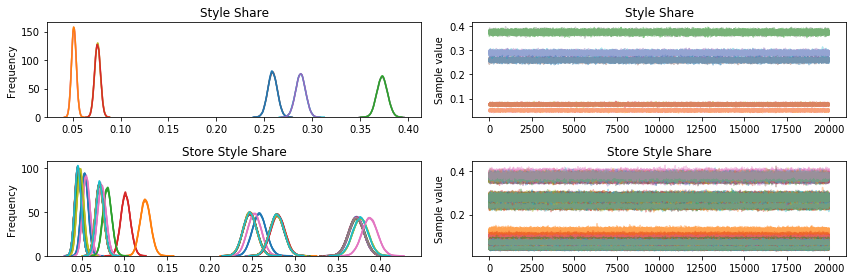

In [250]:
pm.traceplot(pp_style_trace);

In [222]:
# (df_store_style_demand['style'] + ' ' + df_store_style_demand['store']).values

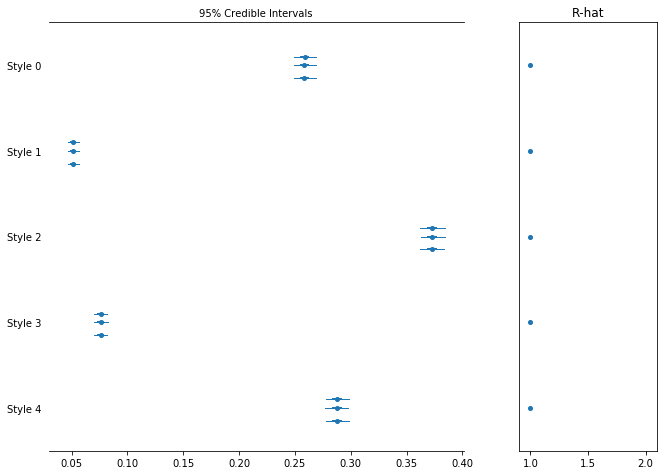

In [253]:
plt.figure(figsize=(10, 7))
pm.forestplot(pp_style_trace, varnames=['Style Share'], ylabels=df_style_demand['style'].values);

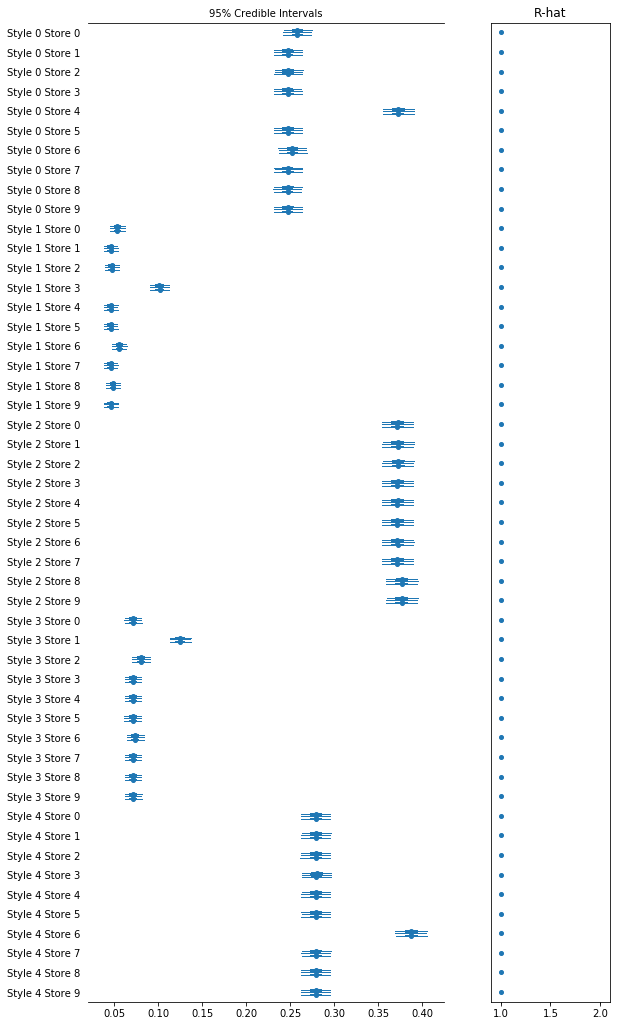

In [251]:
plt.figure(figsize=(10, 16))
pm.forestplot(pp_style_trace, varnames=['Store Style Share'], ylabels=(df_store_style_demand['style'] + ' ' + df_store_style_demand['store']).values);

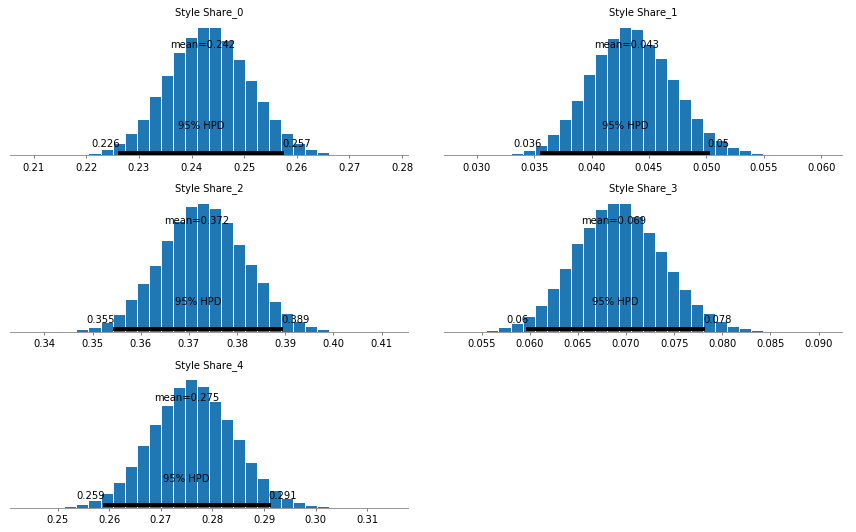

In [263]:
with style_model:
    pm.plot_posterior(style_trace, varnames=['Style Share'])

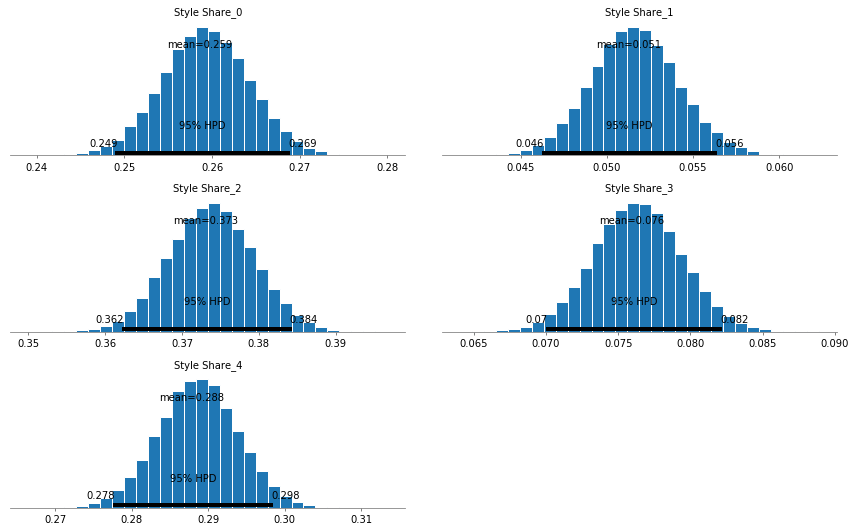

In [265]:
with partial_pooled_style_model:
    pm.plot_posterior(pp_style_trace, varnames=['Style Share'])

In [266]:
with partial_pooled_style_model:
    pp_style_ppc = pm.sample_ppc(pp_style_trace)

100%|██████████| 20000/20000 [00:05<00:00, 3542.57it/s]


0


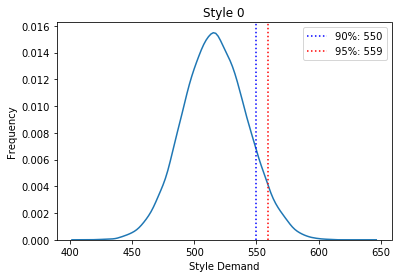

1


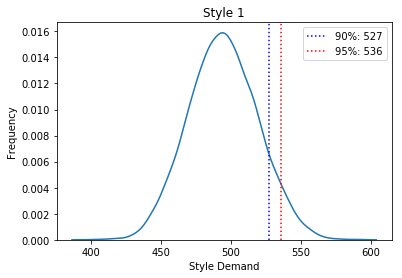

2


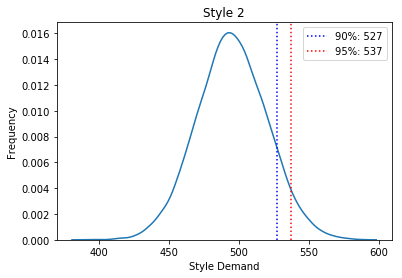

3


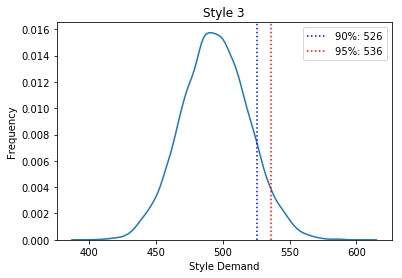

4


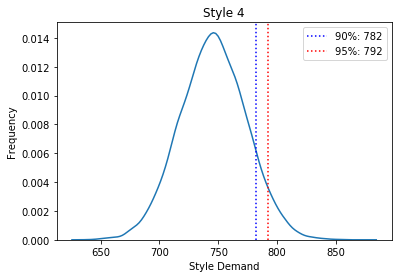

In [269]:
for i, s in df_style_demand.iterrows():
    print(i)
    dt = pp_style_ppc['Store Style Demand'][:, i]
    quantiles = pm.quantiles(dt, [75, 90, 95])

#     obs_mean = int(s['forecasted_style_demand'])
    
    ax = plt.subplot()
    sns.distplot(dt, 
                 kde=True, hist=False, ax=ax)
#     ax.axvline(obs_mean, c='k', alpha=0.4, linestyle='dotted', label=f'Fcst: {obs_mean}')
    ax.axvline(quantiles[90], c='b', linestyle='dotted', label=f'90%: {quantiles[90]}')
    ax.axvline(quantiles[95], c='r', linestyle='dotted', label=f'95%: {quantiles[95]}')
    ax.set(title=s['style'], xlabel='Style Demand', ylabel='Frequency')
    plt.legend(loc='best')
    plt.show()

In [ ]:
N = len(df_store_style_demand)

with pm.Model() as store_style_model:

    store_style_share = pm.Beta('Store Style Share', 
                          alpha=df_store_style_demand['store_style_demand'].values, 
                          beta=prior_customers - df_store_style_demand['store_style_demand'].values, 
                          shape=N)
    
    store_style_demand = pm.Binomial('Store Style Demand', 
                               n=forecasted_customers, 
                               p=store_style_share, 
                               observed=df_store_style_demand['forecasted_store_style_demand'].values)